# MonaLIA: Knowlege Base Dashboard

Visualizations of the Joconde KB context and distance similarities 

In [1]:
from __future__ import print_function

import os
import sys

import numpy as np
import pandas as pd

import SPARQLWrapper

from  textwrap import wrap

import ipywidgets as widgets

from IPython.display import display, HTML, Javascript

from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import triu

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import MonaLIA library from the package in the MonaLIA 2.0 project
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
from MonaLIA.util import metadata_helpers as metadata
from MonaLIA.util import visualization_helpers as vis_helpers

importlib.reload(metadata)
importlib.reload(vis_helpers)

<module 'MonaLIA.util.visualization_helpers' from 'C:\\Users\\abobashe\\Documents\\MonaLIA\\MonaLIA\\util\\visualization_helpers.py'>

In [3]:
print('SPARQLWrapper ver.', SPARQLWrapper.__version__)
print('Pandas ver.', pd.__version__)

SPARQLWrapper ver. 1.8.5
Pandas ver. 1.1.1


In [4]:
wds_Joconde_Corese = 'http://localhost:8080/sparql'

In [5]:
def my_tokenizer(s):
    return list(filter(None, set(s.split('+'))))

def calc_coocurrence_marix(data, tokenizer=my_tokenizer):
    
    vectorizer = CountVectorizer(tokenizer=tokenizer) 

    # Vectorize labels
    X = vectorizer.fit_transform(data)
    #print(vectorizer.get_feature_names())

    # Calculate cooccurence matrix
    cm, diag = cooccurence_matrix(X, symmetry=True)

    return vectorizer, cm, diag

def cooccurence_matrix(X, symmetry=True):
    Xc = (X.T * X)

    Xd = Xc.diagonal()
    Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
    
    if (not symmetry):
        Xc = triu(Xc) 
    Xc.eliminate_zeros()
    
    return Xc, Xd

def cooccurence_dictionary(vectorizer, xc):
    feature_names = vectorizer.get_feature_names()
    cooccurence_dict = { (feature_names[i], feature_names[j]): v for (i,j), v in sorted(xc.todok().items(), key=lambda x: x[1], reverse=True)}
    return cooccurence_dict

def Tversky_index_dictionary(vectorizer, xc, diag, alpha=0.0, beta=1.0):
    feature_names = vectorizer.get_feature_names()
    cooccurence_dict = { (feature_names[i], feature_names[j]): v/(v + alpha*(diag[i]-v) + beta*(diag[j]-v))  for (i,j), v in xc.todok().items()}
    cooccurence_dict = { (i,j): v for (i,j), v in sorted(cooccurence_dict.items(), key=lambda x: x[1], reverse=True)}
    return cooccurence_dict


def similarity_index_to_dataframe(vectorizer, xc, diag, alpha=0.0, beta=1.0):
    #return pd.DataFrame(cm.toarray(), columns=vectorizer.get_feature_names(), index=vectorizer.get_feature_names())
    feature_names = vectorizer.get_feature_names()
    
    coocc_list = sorted(xc.todok().items(), key=lambda x: x[1], reverse=True)
    
    d = {'label_A': [feature_names[i] for (i,j), v in coocc_list],
         'label_B': [feature_names[j] for (i,j), v in coocc_list],
         'cooccurrence_count': [v for (i,j), v in coocc_list],
         'label_A_count' : [diag[i] for (i,j), v in coocc_list],
         'label_B_count' : [diag[j] for (i,j), v in coocc_list],
       #  'n_cooccurrence_count': [v/(diag[i]+ diag[j]- v) for (i,j), v in coocc_list],
         'Jaccard_index': [v/(diag[i]+ diag[j]- v) for (i,j), v in coocc_list],
       #  'n_cooccurrence_count_asym': [v/(diag[j]) for (i,j), v in coocc_list],
         'Tversky_index': [v/(v + alpha*(diag[i]-v) + beta*(diag[j]-v)) for (i,j), v in coocc_list],
       #  'Tversky_index_inv': [v/(v + beta*(diag[i]-v) + alpha*(diag[j]-v)) for (i,j), v in coocc_list],
        }
    return pd.DataFrame(d)

def inverse_index(Jaccard_index, Tversky_index):
    return (Jaccard_index*Tversky_index ) / (Tversky_index - Jaccard_index + Jaccard_index*Tversky_index)   

In [6]:
# vizualization functions

def barplot_pcnt(x, y, hue=None, palette="Blues_r", x_label = '', y_label='', show_data_labels=True, figure=None):
    
    import seaborn as sns
    
    if( figure is None):
        figure=plt.figure(figsize=(12, 5)) 
    
    if show_data_labels:
        sns.set(style='white')
    else:
        sns.set(style='whitegrid')    
    
    ax = sns.barplot( x, y, hue=hue, palette=palette, ci = None) 

    ax.xaxis.tick_bottom() # x axis at the bottom
    ax.xaxis.set_label_text(x_label)
    ax.yaxis.set_label_text(y_label)
    
    if show_data_labels:
        data_label_offset = 1.5 * x.max() / 100
        for p in ax.patches:
            width = p.get_width()
            ax.text(width + data_label_offset ,
                    p.get_y()+p.get_height()/2. + 0.2,
                    '{:1.0f}'.format(width),
                    ha="center")
    #sns.despine()
    
    return figure



def bubble_plot(x,y,z, color="blue", zoom=1000, figure=None, scale=False, percent=False):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if( figure is None):
        figure=plt.figure(figsize=(18, 18))

    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

    tick_labels = list(set(x).union(set(y)))
    xticks_sorted = sorted(tick_labels, reverse=False)
    x = [xticks_sorted.index(l) for l in x]
    
    yticks_sorted = sorted(tick_labels, reverse=True)
    y = [yticks_sorted.index(l) for l in y]
    
    #scale z
    if scale:
        z = ((z - z.min()) / (z.max()-z.min())) 
        #z = z.transform(np.exp)
        
    if percent:
        z = z * 100
        zoom = zoom / 100

    plt.xticks(range(len(xticks_sorted)), xticks_sorted, rotation=90)
    plt.yticks(range(len(yticks_sorted)), yticks_sorted)
    
    scatter = plt.scatter(x, y, s=z, c=color, alpha=0.0) # hack to get the legend labels
    _, labels = scatter.legend_elements(prop="sizes")
    scatter = plt.scatter(x, y, s=z*zoom, c=color, cmap="Blues", alpha=0.4)
    
    # produce a legend with a cross section of sizes from the scatter
    legend_title = "%s" % ("%" if percent else "")
    handles, _ = scatter.legend_elements(prop="sizes", alpha=0.4, c=color)
    legend2 = plt.legend(handles, labels, loc="center right", title=legend_title, bbox_to_anchor=(1.1,0.5))
    
    plt.show()
    
    return figure

def heatmap_plot(pivot_table, cmap='Blues', x_label = None, y_label=None,annot=False, mask=None, figure=None, limits=None):
    import seaborn as sns

    if( figure is None):
        figure=plt.figure(figsize=(18, 18))
        
    if (limits is None):
        limits = (None , None) 
           
    ax = sns.heatmap(pivot_table, cmap=cmap,  annot=annot, square=True, mask=mask, 
                     vmin = limits[0], vmax=limits[1], 
                     cbar_kws={"shrink": 0.8}) #, vmax=12.0)

    ax.xaxis.tick_top() # x axis on top
    plt.xticks(rotation=90)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_label_text(x_label)
    ax.yaxis.set_label_text(y_label)
    
    plt.show()

    return figure

## Calculate the co-occurrence of human annotated categories in subset

Query Joconde KB for all the artworks records that contain are annotated with one of the subset of 40 categories or their subcategories

In [7]:
query_target_coocurence = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select 
        ?notice
        (group_concat(distinct ?topCategory_label; separator="+") as ?target_labels)
		(group_concat(distinct ?subCategory_label;  separator="+") as ?actual_labels)
        (sample(?noticeRepresentation) as ?repr)
where { 

       { 
            select (?classifierClass_label as ?topCategory_label )
            where 
              {
                ?classifierType ml:vocabID "REPR" .
                ?classifier rdfs:subClassOf ?classifierType.
                ?classifier rdfs:label "40_classes". #?classifierName.
                ?classifier ml:conatainsClass [a ?classifierClass; skos:prefLabel ?classifierClass_label]

                #filter (?classifierClass_label = "chien"@fr)
              }
        }
                  

        ?topCategory a jcl:Term;
               skos:prefLabel ?topCategory_label;
               skos:narrower* ?subCategory.

        ?subCategory  skos:prefLabel ?subCategory_label.

        ?notice jcl:noticeReprTerm ?subCategory;
                jcl:noticeHasImage true;               
                jcl:noticeRef ?noticeReference.
                
        optional {
            ?notice jcl:noticeRepr ?noticeRepresentation.
        }  
            
                    
}
group by ?notice 
#order by ?notice ?topCategory_label
'''

In [8]:
%time query_coocurence_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_target_coocurence)
print(query_coocurence_df.shape)

Wall time: 2min 2s
(97467, 4)


Calculate Jaccard (symmetric) and Tverski (asymmetric, alpha=0, beta=1) indices for pairs of categories (A, B).


$$JaccardIndex = \frac{|A \cap B|}{|A \cup B|}$$

$$TverskyIndex = \frac{|A \cap B|}{|A \cap B| + \alpha|A-B| + \beta|B-A|} = \frac{|A \cap B|}{|A \cap B| + |B-A|} = \frac{|A \cap B|}{|B|}, $$
where $\alpha$=0.0 and $\beta$=1.0


https://en.wikipedia.org/wiki/Tversky_index

In [9]:
vectorizer, cm, diag =  calc_coocurrence_marix(query_coocurence_df.target_labels)
cooccurrence_df = similarity_index_to_dataframe(vectorizer, cm, diag)
print(cooccurrence_df.shape)

(1558, 7)


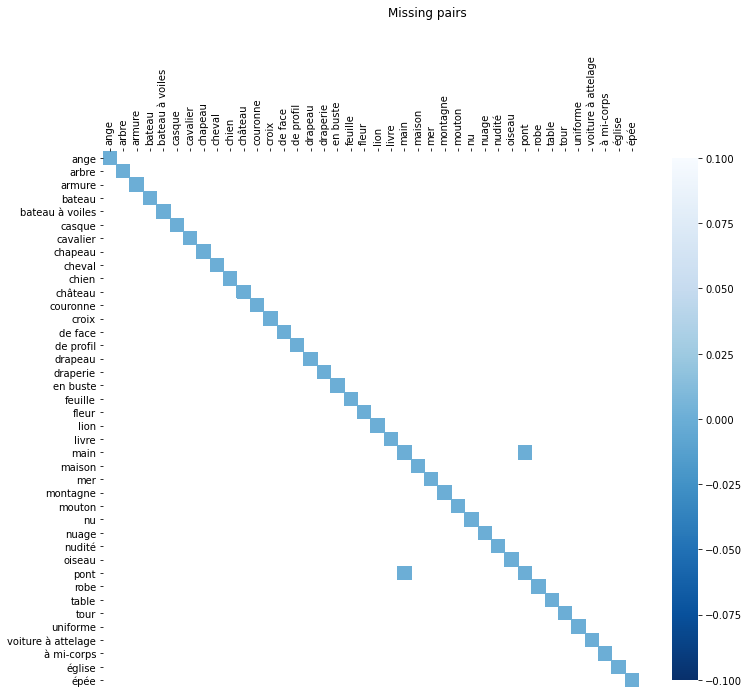

In [10]:
fig = plt.figure(figsize=(12, 12))

fig.suptitle('Missing pairs')

cooccurrence_matrix = cooccurrence_df.pivot('label_A', 'label_B', 'Tversky_index' ).fillna(0.0)#.astype('int32')
mask = cooccurrence_matrix[cooccurrence_matrix == 0]
mask = mask.isna()

sink = heatmap_plot(cooccurrence_matrix, figure=fig, cmap='Blues_r', mask=mask)


CONCLUSIONS:
* Since *bateau à voiles* is a subcategory of category *bateau* their co-occurence is 100% (this datapoint can be removed)

* However the pair (*bateau à voiles*, *bateau*) co-occurred over 35% times meaning that both ategories exist in the annotation. [Which potentially can be used in "noise" detecteion as if specific category is specified no need to specify the more general category]

* 9 pairs of high co-occurernce was discovered. [These pairs can be used in "silence" detection to suggest that if there is a label B then there could be also label A, e.g. if there is an *caalier* then there is also could be a *cheval* although . ]

## Calculate the distance between categories in Garnier Thesaurus

Query Jocomnde KB for the graph distances between the subset of 40 categories.

In [11]:
query_distance = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>

select  ?label_A
        ?path_A
        ?depth_A
        ?label_B
        ?path_B
        ?depth_B


        (ml:common_parents(?list_A, ?list_B) as ?common_parent_count)
        (ml:distance(?list_A, ?list_B) as ?distance)
 
where {

  {
      select ?label_A ?label_B 
      {
          ?classifier rdfs:label "40_classes"; 
                      ml:conatainsClass [skos:prefLabel ?label_A];
                      ml:conatainsClass [skos:prefLabel ?label_B].
          filter (?label_A != ?label_B)
      }
      order by ?label_A ?label_B
      #limit 10
  }

    { 
        select ?label_A 
            (group_concat(distinct ?parent_A; separator="+") as ?path_A)
            (max(?path_A_length) as ?depth_A)
            (sample(?A) as ?uri_A)
            (aggregate(distinct ?parent_A) as ?list_A)
        where 
        {
          ?A a skos:Concept;
                 skos:prefLabel  ?label_A; 
                 skos:broader* :: $path ?parent.
          ?parent skos:prefLabel ?parent_A.
          bind(kg:pathLength($path) as ?path_A_length).
        }
        group by ?label_A
        order by ?label_A
    }
    
    {
      select ?label_B 
             (group_concat(distinct ?parent_B; separator="+") as ?path_B)
             (max(?path_B_length) as ?depth_B)
             (sample(?B) as ?uri_B)
             (aggregate(distinct ?parent_B) as ?list_B)
        where 
        {
          ?B a skos:Concept;
                 skos:prefLabel  ?label_B; 
                 skos:broader* :: $path ?parent.
          ?parent skos:prefLabel ?parent_B.
          bind(kg:pathLength($path) as ?path_B_length).
        }
        group by ?label_B
        order by ?label_B
   }
  
  #filter (?label_A !=  ?label_B)
}
order by ?label_A ?label_B

#
# common parents
#
function ml:common_parents(?list1 , ?list2){
	xt:size(?list1) + xt:size(?list2) - xt:size(xt:merge(?list1, ?list2))
}

#
# distance
#
function ml:distance(?list1 , ?list2){
      if( ml:common_parents(?list1 , ?list2) > 0 )
          {xt:size(xt:merge(?list1, ?list2)) * 2 - xt:size(?list1) - xt:size(?list2) }
      else {100}
}

#
# distance without merging list twice (does not really improve the performance)
#
function ml:distance1(?list1 , ?list2){
      let( ?common_parents = ml:common_parents(?list1 , ?list2)){
      if( ?common_parents > 0 )
          { xt:size(?list1) + xt:size(?list2) - ?common_parents * 2 }
      else {100}
      }
}
''' 

In [12]:
%time distance_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_distance)
print(distance_df.shape)

Wall time: 1min 32s
(1560, 8)



#### Calculate weighted distance (from the top and between the categories).

Assign weights of $1/2^{n}$ (where n is the node depth from the top node, enumerating from 1.).

Apply geometric progression sum rules to calculate the weighted distance.

$${depth}_{weighted}=\frac{a (1-r^{d+1})}{1-r} - 1,$$, where 
$$a= 1, r= \frac{1}{2}, d= number of edges from the top $$   

Consequently the weighted distance or similarity between the nodes would be calculated as

$$ distance_{weighted}=depthA_{weighted} + depthB_{weighted} - (commonParentsPath - 1)_{weighted} *2$$

Similarity can be calculated as a reverse of distance, when categories are connected and the maximum possilbe distance = 2
$$ similarity = \frac{2 - distance_{weighted}}{2} $$ 
otherwise
$$ similarity = 0.0 $$




In [13]:
def weighted_depth(depth):
    return (1-0.5**depth)/0.5

def weighted_depth_1(depth):
    return (1-0.5**(depth+1))/0.5 - 1

In [14]:
distance_df = distance_df.astype({'depth_A': 'int32',
                                 'depth_B': 'int32',
                                 'common_parent_count': 'int32',
                                 'distance': 'int32' })

distance_df['w_depth_A'] = distance_df.depth_A.apply(weighted_depth_1)
distance_df['w_depth_B'] = distance_df.depth_B.apply(weighted_depth_1)

distance_df['w_distance'] = distance_df.apply(lambda x: x.w_depth_A + 
                                                  x.w_depth_B - 
                                                  weighted_depth_1(x.common_parent_count-1) * 2 , axis=1)
max_distance = distance_df[distance_df.common_parent_count > 0].w_distance.max()
distance_df['similarity'] = distance_df.apply(lambda x: (2 - x.w_distance) /2 if x.common_parent_count > 0 else 0.0, axis=1)

distance_df['rank_w_distance'] = distance_df.w_distance.rank(method='first')
distance_df['rank_distance'] = distance_df.distance.rank(method='first')

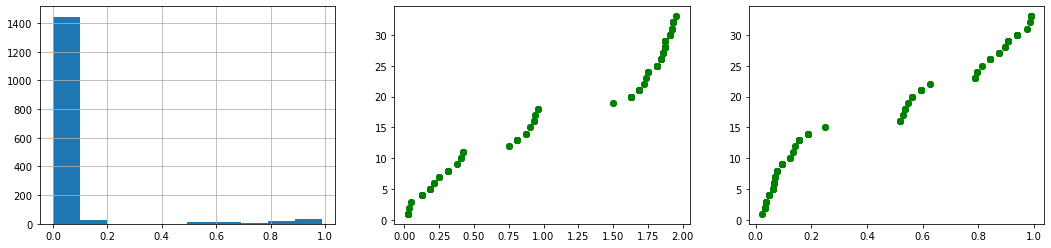

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches((18, 4))
distance_df.similarity.hist(ax=ax1)

ax2.scatter(x = distance_df.loc[distance_df.common_parent_count > 0].w_distance,
            y = distance_df.loc[distance_df.common_parent_count > 0].w_distance.rank(method='dense'),
            color='green')

ax3.scatter(x = distance_df.loc[distance_df.common_parent_count > 0].similarity,
            y = distance_df.loc[distance_df.common_parent_count > 0].similarity.rank(method='dense'),
            color='green')
#distance_df.loc[distance_df.common_parent_count > 0].plot(x='w_distance', y='rank_w_distance', )

C:\Users\abobashe\Anaconda3\lib\site-packages\seaborn\matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 864x864 with 0 Axes>

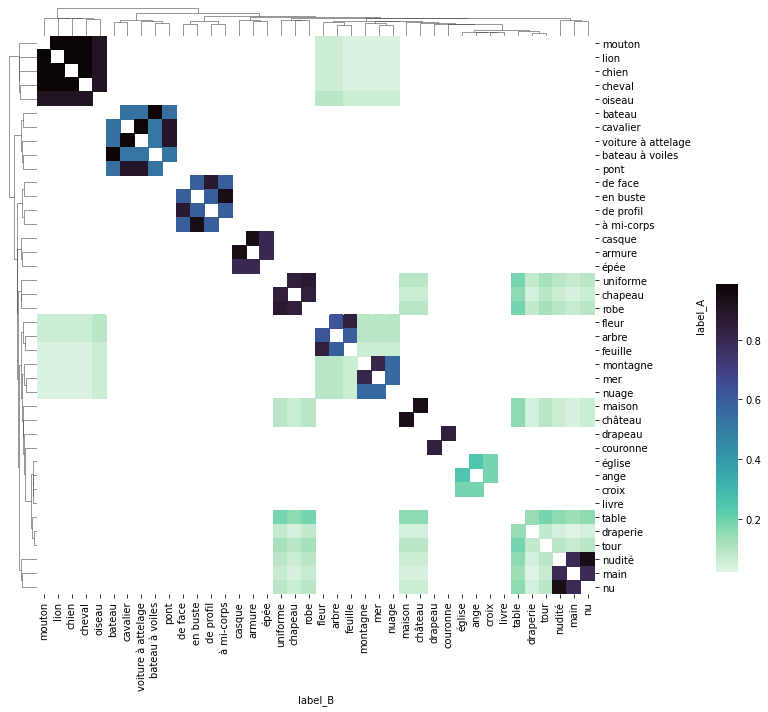

In [22]:
fig=plt.figure(figsize=(12, 12))

fig.suptitle('Similarity matrix between subset of categories in Garnier Thesaurus')

similarity_matrix = distance_df.pivot('label_A', 'label_B', 'similarity' ).fillna(0.0)
mask = similarity_matrix[similarity_matrix > 0]
mask = mask.isna()
# Generate a mask for the upper triangle
#mask = mask | np.triu(np.ones_like(mask, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#fig = heatmap_plot(similarity_matrix, cmap="Greens", annot=False, mask=mask, figure=fig, limits=(0.0, 1.0))

sns.clustermap(similarity_matrix, cmap="mako_r", mask=mask, figsize=(10, 10), dendrogram_ratio=(0.05, 0.05),
               cbar_pos=(1, .2, .03, .4))

CONCLUSIONS:
* The Joconde KB is a graph containing 13 unconnected hierarchical trees. 

* The 40 categories subset appears in 8 of these trees.

* For the sake of calculations not connected labels (categories) are given distance 100. 

* Only 266 out of 1560 pairs of categories are connected (17%).

* The closest categories are (*bateau à voiles*, *bateau*) with distance 1 meaning that one is an immediate subcategory of another.

## Query the relationship graph between the categories in Garnier Thesaurus

see the networkx graph in the Dashboard section

In [23]:
query_Garnier_relations_graph = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>

select ?label_A
?parent_label
?parent_parent_label
 
where {

  {
      select ?label_A 
      {
          ?classifier rdfs:label "40_classes"; 
                      ml:conatainsClass [skos:prefLabel ?label_A];
      }
      order by ?label_A
      #limit 10
  }

   ?A a skos:Concept;
                 skos:prefLabel  ?label_A; 
                 skos:broader* :: $path ?parent.
                 ?parent skos:prefLabel ?parent_label.
   optional{
   
      ?parent skos:broader/skos:prefLabel ?parent_parent_label
   }
                 
    
}

''' 

In [24]:
%time relations_Garnier_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_Garnier_relations_graph)
print(relations_Garnier_df.shape)

Wall time: 1min 40s
(215, 3)


## Compare similarity index and Garnier Thesaurus distance 

In [25]:
cooccurrence_distance_df = cooccurrence_df.merge(distance_df.loc[:, ['label_A', 'label_B', 'distance', 'w_distance', 'common_parent_count']],
                                                left_on=['label_A', 'label_B'], 
                                                right_on=['label_A', 'label_B'],    
                                                how='right')

cooccurrence_distance_df.fillna(0.0, inplace=True)
cooccurrence_distance_df['pair'] = cooccurrence_distance_df.apply(lambda x: '(%s, %s)' % (x.label_A,  x.label_B),  axis=1)    

#### Step 1. Take top pairs with highest similarity index (ranked high to low)


#### Step 2. Rank the above pairs by weighted distance (low to high)

The distance have multiple duplicated values. There are two ways to rank the values 
     - with ties (method='dense')
     - without ties (method='first')

#### Step 3. Calculate the rank difference between ranked list obtained in step 1 & 2 for each pair

$$d(c1,l2)= similarity_R(c1,c2) - distance_R(c1,c2)$$

#### Step 4. Rank the pairs by d(c1-c2) (low to high)

CONCLUSIONS:
* The negative rank difference indicates the pairs that are not related by Garnier Thesaurus but related by the context. These pairs can be related to improve labeling for image classification. The direction of the link is suas as category A is likely to appear with category B.  

* This analysis confirms that we were correct by relating the (*cheval*, *cavalier*) categories during the MonaLIA 2.0 phase.

* It also point out that other categories such as (*bateau*, *mer*) and (*cheval*, *voiture à attelage*) can be related.

## Calculate similarity between categories in DBPedia

Create the mapping of Joconde ontology categories and DBPedia by running another notebook:
http://localhost:8888/notebooks/Documents/MonaLIA/MonaLIA%202.0/Cooccurence%20Study/MonaLIA.Graph%20Similarity%20Study.query%20and%20save.ipynb

or 

http://localhost:8888/notebooks/Documents/MonaLIA/MonaLIA%202.0/Cooccurence%20Study/MonaLIA.Graph%20Similarity%20Study.load%20and%20plot.ipynb


In Corese there is a function that computes a semantic similarity between classes:

kg:similarity(?c1, ?c2)

The similarity is a number between 0 and 1

It is computed according to the length of the path between the two
classes and by taking into account the depth of the classes where the
length of an elementary step is 1/(2^n) where n is the depth in the
hierarchy. That is, the deepest the most similar (the similarest :-))

Actually it works with classes and rdfs:subClassOf

In [27]:
dbp_graph_name = 'DBPedia_unrooted'

In [32]:
query_dbpedia_similarity =  '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>

select  *

where {

  graph ml:%s { 
       
     ?jcl_category_A  ml:label ?label_A;
                      skos:closeMatch ?dbp_category_A.

     ?jcl_category_B  ml:label ?label_B;
                      skos:closeMatch ?dbp_category_B.

      filter (?label_A != ?label_B)      
            
      bind(kg:similarity(?dbp_category_A, ?dbp_category_B) as ?similarity)
}
   
}
''' % (dbp_graph_name)

In [33]:
%time distance_dbp_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_dbpedia_similarity)
print(distance_dbp_df.shape)

Wall time: 191 ms
(1332, 7)


In [34]:
distance_dbp_df.similarity = distance_dbp_df.similarity.str.replace(',', '.')
distance_dbp_df = distance_dbp_df.astype({'similarity': 'float' })
distance_dbp_df['w_distance'] = distance_dbp_df.apply(lambda x: 1 - x.similarity, axis=1)

## Query the relations between the categories in the DBPedia extracted graph

see the networkx graph in the Dashboard section

In [36]:
query_dbp_thesaurus_graph = '''
prefix ml: <http://ns.inria.fr/monalia/>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select ?sub_category ?parent_category ?sub_category_label ?parent_category_label
where {
     graph ml:%s{
       ?sub_category rdfs:subClassOf ?parent_category ;
                     skos:prefLabel ?sub_category_label.
       ?parent_category skos:prefLabel ?parent_category_label.       
       }
}
order by 
?sub_category ?parent_category
''' % (dbp_graph_name)

In [37]:
%time relations_DBPedia_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_dbp_thesaurus_graph)
print(relations_DBPedia_df.shape)

Wall time: 63.7 ms
(1444, 4)


## Graph similarity analysis between Garnier Thesaurus and DBPedia graphs

In [38]:
def dbp_similarity_avg(row):
    
    v = distance_new_df.loc[(distance_new_df.label_A == row.label_B) & (distance_new_df.label_B == row.label_A), 'similarity_y']
   
    return max(row.similarity_y, v.item()) 

In [39]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

distance_new_df = distance_df.merge(distance_dbp_df.loc[:, ['label_A', 'label_B', 'similarity']],
                                                left_on=['label_A', 'label_B'], 
                                                right_on=['label_A', 'label_B'],
                                                suffixes=('_GT', '_DBP'),
                                                how='left')
distance_new_df['similarity_diff'] = distance_new_df.similarity_GT - distance_new_df.similarity_DBP

distance_new_df['n_similarity_GT'] = min_max_scaler.fit_transform(distance_new_df.similarity_GT.values.reshape(-1, 1))
distance_new_df['n_similarity_DBP'] = min_max_scaler.fit_transform(distance_new_df.similarity_DBP.values.reshape(-1, 1))
distance_new_df['n_similarity_diff'] = distance_new_df.n_similarity_GT - distance_new_df.n_similarity_DBP


#distance_new_df['new_similarity'] = distance_new_df.apply(lambda x: x.similarity_y if x.common_parent_count <= 0 else 0, axis=1)
#distance_new_df['similarity_DBP_max']  = distance_new_df.apply(dbp_similarity_avg, axis=1)

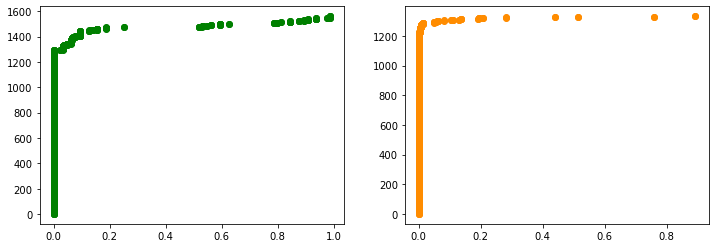

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches((12, 4))

ax1.scatter(x = distance_new_df.loc[distance_new_df.similarity_GT.notna()].similarity_GT,
            y = distance_new_df.loc[distance_new_df.similarity_GT.notna()].similarity_GT.rank(method='first'),
            color='green')

ax2.scatter(x = distance_new_df.loc[distance_new_df.similarity_DBP.notna()].similarity_DBP,
            y = distance_new_df.loc[distance_new_df.similarity_DBP.notna()].similarity_DBP.rank(method='first'),
            color='darkorange')


C:\Users\abobashe\Anaconda3\lib\site-packages\seaborn\matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
C:\Users\abobashe\Anaconda3\lib\site-packages\seaborn\matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 864x864 with 0 Axes>

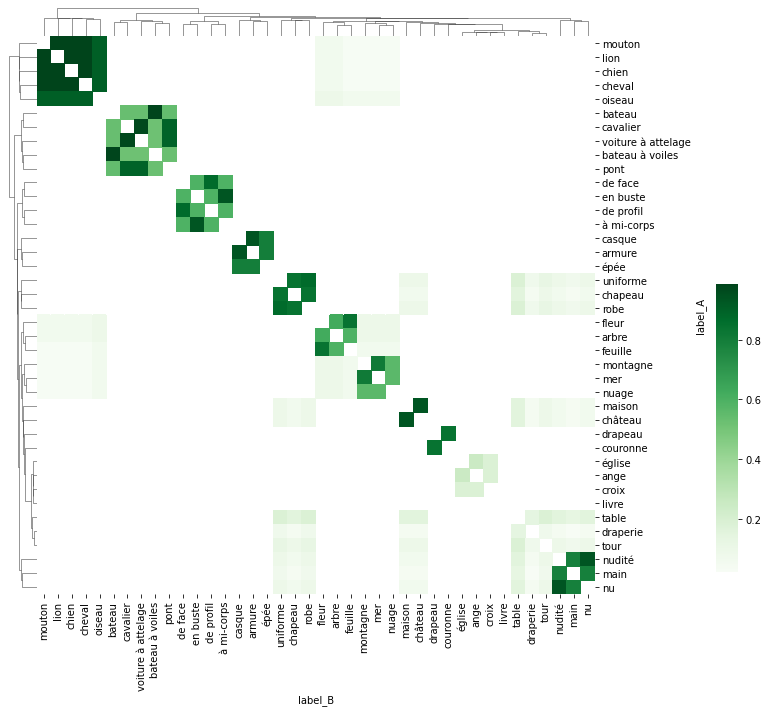

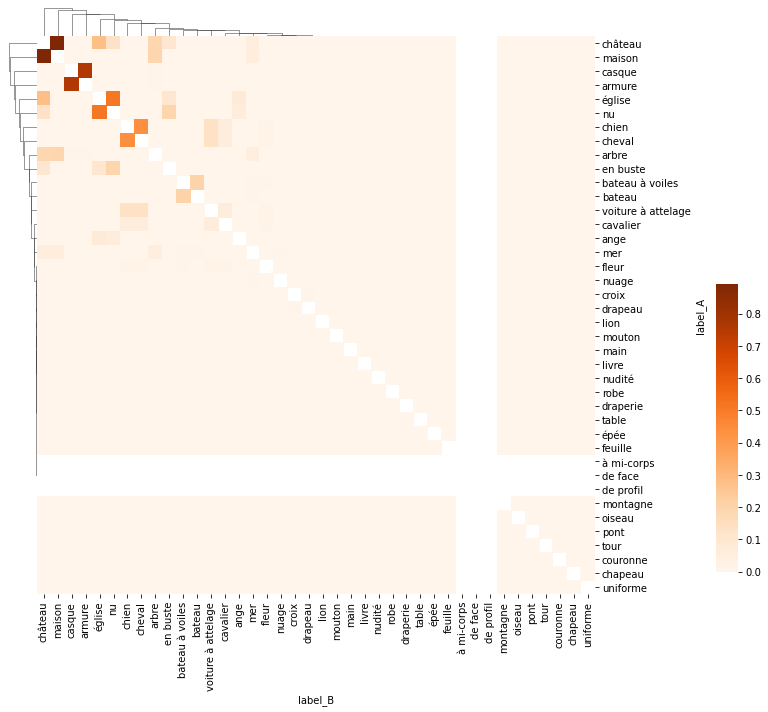

In [48]:
fig=plt.figure(figsize=(12, 12))

similarity_matrix_gt = distance_new_df.pivot('label_A', 'label_B', 'similarity_GT' ).fillna(0.0)
mask = similarity_matrix_gt[similarity_matrix_gt > 0]
mask = mask.isna()

cluster_GT = sns.clustermap(similarity_matrix_gt, cmap="Greens", mask=mask, figsize=(10, 10), dendrogram_ratio=(0.05, 0.05),
               cbar_pos=(1, .2, .03, .4))


similarity_matrix_dbp = distance_new_df.pivot('label_A', 'label_B', 'similarity_DBP' ).fillna(0.0)
mask = similarity_matrix_dbp[similarity_matrix_dbp > 0]
mask = mask.isna()

sns.clustermap(similarity_matrix_dbp, cmap="Oranges", mask=mask, figsize=(10, 10), dendrogram_ratio=(0.05, 0.05),
                              cbar_pos=(1, .2, .03, .4))


<AxesSubplot:xlabel='label_B', ylabel='label_A'>

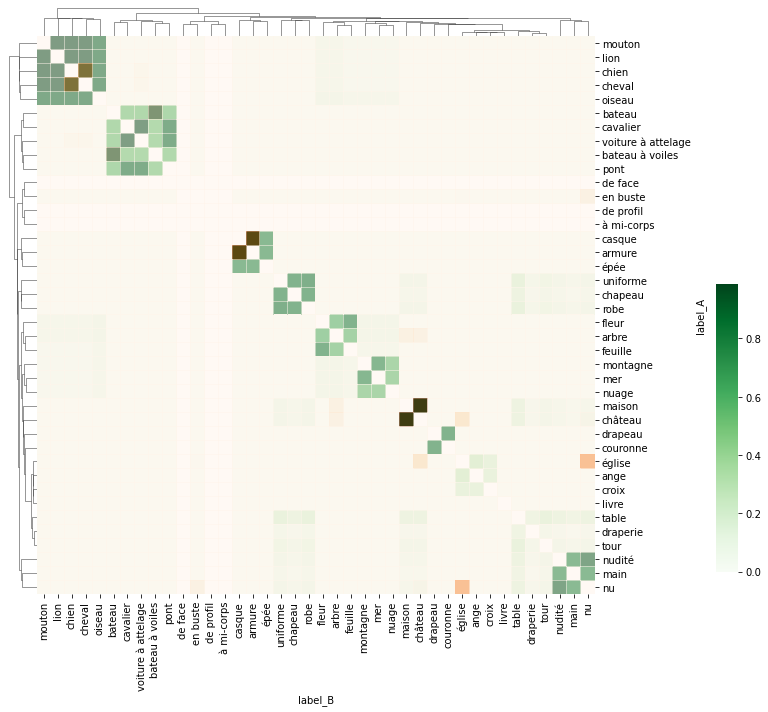

In [51]:
cluster_GT = sns.clustermap(similarity_matrix_gt, cmap="Greens", mask=mask, figsize=(10, 10), dendrogram_ratio=(0.05, 0.05),
               cbar_pos=(1, .2, .03, .4))
sns.heatmap(similarity_matrix_dbp.iloc[cluster_GT.dendrogram_row.reordered_ind, cluster_GT.dendrogram_col.reordered_ind],
           cmap="Oranges",
            cbar=False,
            ax=cluster_GT.ax_heatmap,
            vmin=0.105,
            alpha = 0.5
           )

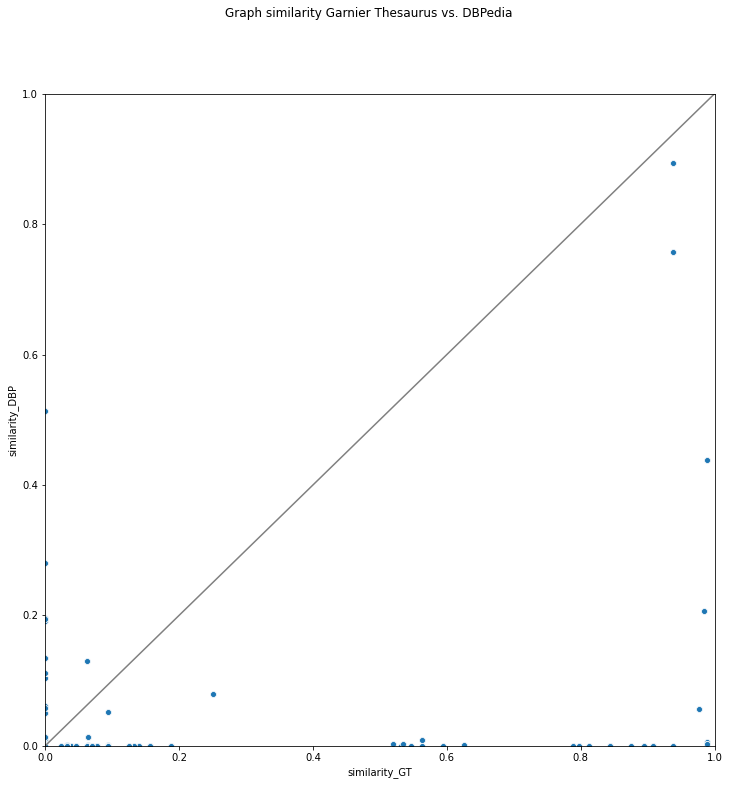

In [53]:
import matplotlib.lines as lines

fig=plt.figure(figsize=(12, 12))

fig.suptitle('Graph similarity Garnier Thesaurus vs. DBPedia')
ax = sns.scatterplot(x=distance_new_df.similarity_GT,
            y=distance_new_df.similarity_DBP)

ax.xaxis.tick_bottom() # x axis at the bottom
#ax.xaxis.set_label_text(x_label)
#ax.yaxis.set_label_text(y_label)


ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

X_plot = np.linspace(0, 1, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='grey')
plt.show()

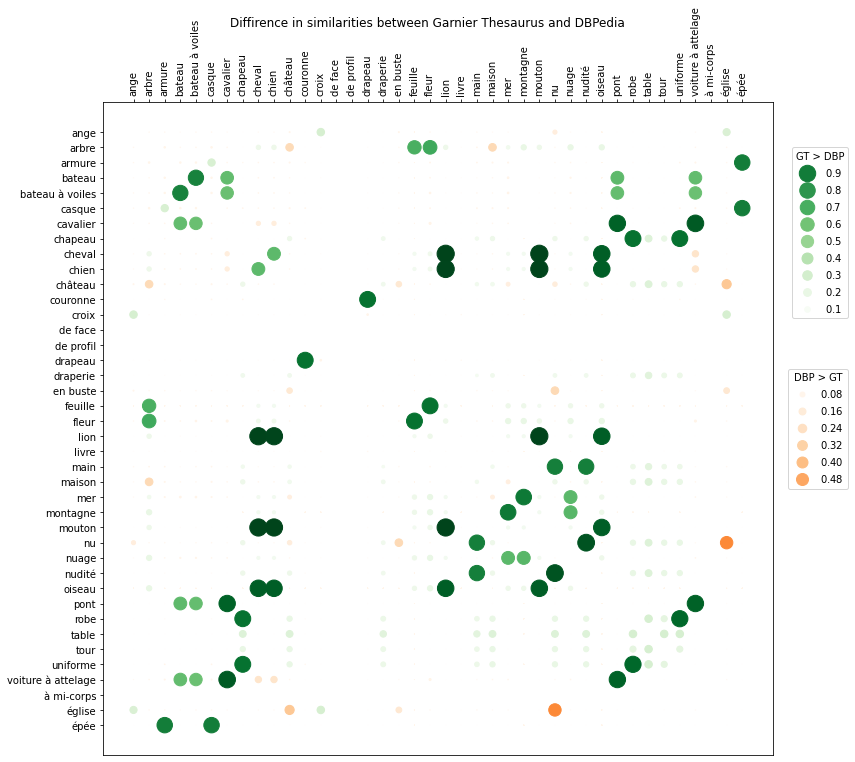

In [54]:
figure=plt.figure(figsize=(12, 12))

figure.suptitle('Diffirence in similarities between Garnier Thesaurus and DBPedia')

x = distance_new_df.label_A
y = distance_new_df.label_B

z = distance_new_df.similarity_diff
z_gt = z.apply(lambda x: x if x > 0 else 0.0)
z_dbp = z.apply(lambda x: -x if x < 0 else 0.0)

scale = False
zoom = 300
num_legend = 8

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

tick_labels = list(set(x).union(set(y)))
xticks_sorted = sorted(tick_labels, reverse=False)
x = [xticks_sorted.index(l) for l in x]

yticks_sorted = sorted(tick_labels, reverse=True)
y = [yticks_sorted.index(l) for l in y]

#scale z
if scale:
    z_gt = ((z_gt - z_gt.min()) / (z_gt.max()-z_gt.min())) 
    z_dbp = ((z_dbp - z_dbp.min()) / (z_dbp.max()-z_dbp.min())) 
    #z = z.transform(np.exp)

plt.xticks(range(len(xticks_sorted)), xticks_sorted, rotation=90)
plt.yticks(range(len(yticks_sorted)), yticks_sorted)

# plot GT
#######################################################################################################
scatter = plt.scatter(x, y, s=z_gt*zoom, c=z_gt, cmap="Greens", alpha=1.0)#, vmin=0.0, vmax=1.0)

# create better legend
handles_gt_color, _ = scatter.legend_elements(prop="colors", num=num_legend)
handles_gt_size , labels_gt = scatter.legend_elements(prop="sizes", num=num_legend, func=(lambda x: x /zoom ))

#combine color and size in one legend
for i, h in enumerate(handles_gt_size):
    h.set_color(handles_gt_color[i].get_color())

#reverse legend for a divergence effect
handles_gt_size.reverse()
labels_gt.reverse()

ax = figure.axes[0]
legend_gt = ax.legend(handles_gt_size, labels_gt, loc="center right", title='GT > DBP', bbox_to_anchor=(1.12,0.8))
ax.add_artist(legend_gt)

# plot DBP
########################################################################################################

scatter = ax.scatter(x, y, s=z_dbp*zoom, c=z_dbp, cmap="Oranges", alpha=1.0, vmin=0.0, vmax=1.0)
handles_dbp_color, _ = scatter.legend_elements(prop="colors", num=num_legend)
handles_dbp_size , labels_dbp = scatter.legend_elements(prop="sizes", num=num_legend, func=(lambda x: x /zoom ))

#combine color and size in one legend
for i, h in enumerate(handles_dbp_size):
    h.set_color(handles_dbp_color[i].get_color())

legend_dbp = ax.legend(handles_dbp_size, labels_dbp, loc="center right", title='DBP > GT', bbox_to_anchor=(1.12,0.5))

plt.show()

### Top 5 differences

In [56]:
distance_new_df.head()

,label_A,path_A,depth_A,label_B,path_B,depth_B,common_parent_count,distance,w_depth_A,w_depth_B,w_distance,similarity_GT,rank_w_distance,rank_distance,similarity_DBP,similarity_diff,n_similarity_GT,n_similarity_DBP,n_similarity_diff
0,ange,ange+être surnaturel+vie religieuse,2,arbre,arbre+espèce végétale+végétal+la nature,3,0,100,0.75,0.87500,3.62500,0.0,271.0,267.0,0.000460,-0.000460,0.0,0.000515,-0.000515
1,ange,ange+être surnaturel+vie religieuse,2,armure,armure+arme défensive+arme+armement+armement-v...,4,0,100,0.75,0.93750,3.68750,0.0,315.0,268.0,0.000497,-0.000497,0.0,0.000557,-0.000557
2,ange,ange+être surnaturel+vie religieuse,2,bateau,bateau+moyen de transport par eau+transport pa...,4,0,100,0.75,0.93750,3.68750,0.0,316.0,269.0,0.000116,-0.000116,0.0,0.000129,-0.000129
3,ange,ange+être surnaturel+vie religieuse,2,bateau à voiles,bateau à voiles+bateau+moyen de transport par ...,5,0,100,0.75,0.96875,3.71875,0.0,407.0,270.0,0.000430,-0.000430,0.0,0.000481,-0.000481
4,ange,ange+être surnaturel+vie religieuse,2,casque,casque+arme défensive+arme+armement+armement-v...,4,0,100,0.75,0.93750,3.68750,0.0,317.0,271.0,0.000497,-0.000497,0.0,0.000557,-0.000557


In [59]:
if ('pair' not in distance_new_df.columns):
    distance_new_df.insert(0, 'pair', 
                         distance_new_df.apply(lambda row: '(%s, %s)' % (row.label_A,  row.label_B),  axis=1))
    distance_new_df.insert(1, 'pair_odr',
                         distance_new_df.apply(lambda row: '(%s, %s)' % tuple(sorted((row.label_A,  row.label_B))),  axis=1))

# To get top 5 highest differences on GT side set ascending= False
#                                     DBPedia side set ascending= True                      
distance_new_df.loc[:, ['pair', 'pair_odr', 'similarity_GT', 'similarity_DBP', 'similarity_diff' ]] \
              .drop_duplicates(subset=['similarity_diff', 'pair_odr']) \
              .sort_values(by=['similarity_diff', 'pair_odr'], ascending= True) \
              .head(5).pair_odr

1090         (nu, église)
427     (château, église)
61        (arbre, maison)
689        (en buste, nu)
48       (arbre, château)
Name: pair_odr, dtype: object

CONCLUSIONS:

* Based on DBPedia graph the discovery of new realtions between the categories that are not present in Garnier Thesaurus is possible
* The DBPedia extracted graph results depend on the depth of ancestry in the query, for example skos:broader{0,6} or skos:broader{0,3}
* Deeper ancestry graphs produce some unexpected but not completely illogical results, for ex. linking nude and church. The “trimmed” DBPedia graph produces very logical category connections discovered in DBPedia that can be used as suggestions for the data annotation. 

## Compare similarity index and DBPedia distance 

see the Dashboard section for the visualization

CONCLUSIONS:

The negative rank difference indicates the pairs that are not related or weakly related by the graphs (Garnier Thesaurus and extracted from DBPedia) but related by the context. These pairs can be related to improve labeling for image classification. The direction of the link is such as category A is likely to appear with category B.

Based on Garnier Thesaurus sparsely connected graph analysis: 
* confirmed that we were correct by relating the (cheval, cavalier) categories during the MonaLIA 2.0 phase.
* pointed out that other categories such as (bateau, mer) and (cheval, voiture à attelage) can be related.


Based on DBPedia-extracted densly connected graph analysis:
* agrees that categories  (bateau, mer) can be related.
* aknowleges that the (cheval, cavalier) pais can be related as it is equally high in both rankings.
* blah-blah about   (cheval, voiture à attelage)

## Co-occurrence similarity of predictions

In [60]:
query_predictions_cooccurrence = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>


select  ?notice 
          (group_concat(distinct ?detectedCat_label; separator="+") as ?predictions)
          (min(?detectedScore) as ?minScore)
          (sample(?noticeReference) as ?ref)
          (sample(?noticeRepresentation) as ?repr)

where
{
       
      ?classifierType ml:vocabID "REPR" .
      ?classifier rdfs:subClassOf ?classifierType.
      ?classifier rdfs:label "40_classes". #?classifierName.

      ?notice ml:imageClassifier [ a ?classifier ; ml:detected [ a ?detectedCat; ml:score ?detectedScore] ];
              jcl:noticeRef ?noticeReference.
              
      optional {
            ?notice jcl:noticeRepr ?noticeRepresentation.
      }  

      #?notice ml:imageClassifier [ml:detected [ a ?detectedCat; ml:score ?detectedScore] ].
      ?detectedCat skos:prefLabel ?detectedCat_label.

      FILTER ( ?detectedScore >= 0.90 )
            
} group by ?notice
'''

In [61]:
%time predictions_cooccurrence_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_predictions_cooccurrence)
predictions_cooccurrence_df.shape

Wall time: 40.5 s


(233208, 5)

In [62]:
vectorizer, cm, diag =  calc_coocurrence_marix(predictions_cooccurrence_df.predictions)
pred_cooccurrence_df = similarity_index_to_dataframe(vectorizer, cm, diag)
print(pred_cooccurrence_df.shape)

(1550, 7)


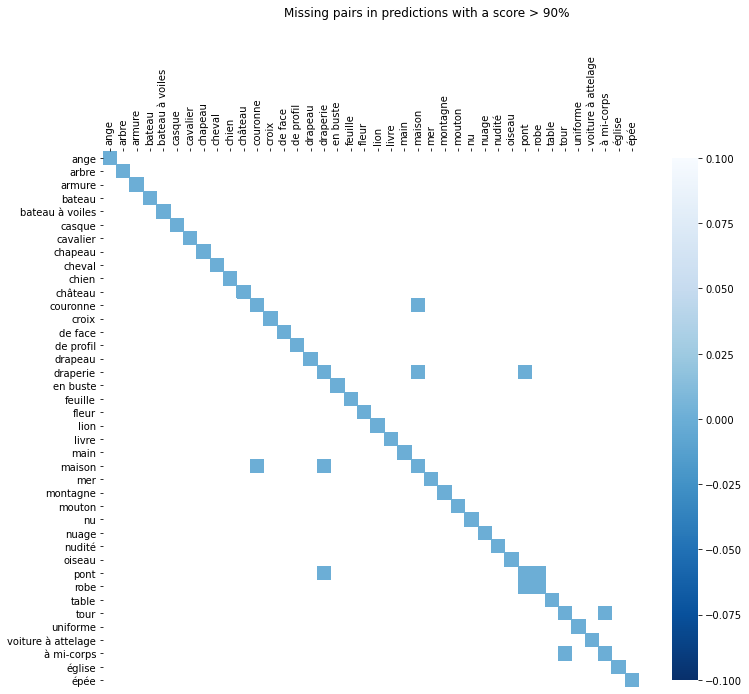

In [63]:
#some pairs are missing
fig = plt.figure(figsize=(12, 12))

fig.suptitle('Missing pairs in predictions with a score > 90%')

cooccurrence_matrix = pred_cooccurrence_df.pivot('label_A', 'label_B', 'Tversky_index' ).fillna(0.0)#.astype('int32')
mask = cooccurrence_matrix[cooccurrence_matrix == 0]
mask = mask.isna()

sink = heatmap_plot(cooccurrence_matrix, figure=fig, cmap='Blues_r', mask=mask)

In [64]:
target_vs_predictions = distance_df.loc[:, ['label_A', 'label_B']].merge(cooccurrence_df.loc[:, ['label_A', 'label_B', 'Jaccard_index', 'Tversky_index']],
                                                left_on=['label_A', 'label_B'], 
                                                right_on=['label_A', 'label_B'],    
                                                how='left')
target_vs_predictions = target_vs_predictions.merge(pred_cooccurrence_df.loc[:, ['label_A', 'label_B', 'Jaccard_index', 'Tversky_index']],
                                                left_on=['label_A', 'label_B'], 
                                                right_on=['label_A', 'label_B'],    
                                                how='left',
                                                suffixes=('_human', '_pred'))

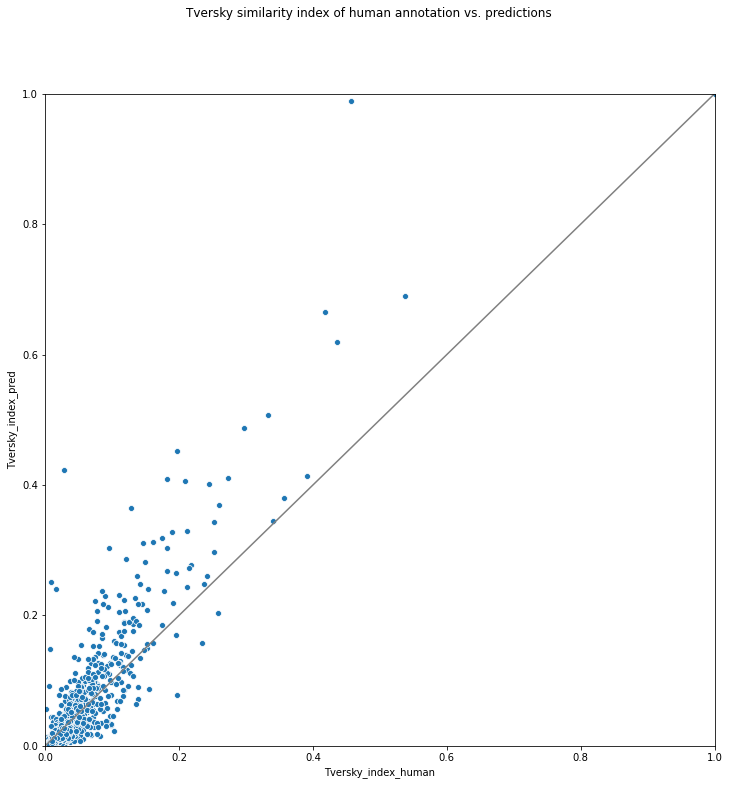

In [66]:
import matplotlib.lines as lines

fig=plt.figure(figsize=(12, 12))

fig.suptitle('Tversky similarity index of human annotation vs. predictions')
ax = sns.scatterplot(x=target_vs_predictions.Tversky_index_human,
            y=target_vs_predictions.Tversky_index_pred)

ax.xaxis.tick_bottom() # x axis at the bottom
#ax.xaxis.set_label_text(x_label)
#ax.yaxis.set_label_text(y_label)


ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

X_plot = np.linspace(0, 1, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='grey')
plt.show()

## Dashboard

### Collect the metrics into one dataframe

In [67]:
# create cummulative dataframe
similarity_df= cooccurrence_df.copy()

similarity_df = similarity_df.merge(distance_df.loc[:, ['label_A', 'label_B', 'distance',  'common_parent_count', 'w_distance', 'similarity']],
                                    left_on=['label_A', 'label_B'], 
                                    right_on=['label_A', 'label_B'],   
                                    how='right')


similarity_df = similarity_df.merge(distance_dbp_df, 
                                    left_on=['label_A', 'label_B'], 
                                    right_on=['label_A', 'label_B'],   
                                    how='left',
                                    suffixes=('_GT', '_DBP'))


similarity_df = similarity_df.merge(pred_cooccurrence_df, 
                                    left_on=['label_A', 'label_B'], 
                                    right_on=['label_A', 'label_B'],   
                                    how='left',
                                    suffixes=('_human', '_pred'))
#similarity_df.fillna(0.0)
similarity_df.insert(2, 'pair', 
                     similarity_df.apply(lambda row: '(%s, %s)' % (row.label_A,  row.label_B),  axis=1))
similarity_df.insert(3, 'pair_odr',
                     similarity_df.apply(lambda row: '(%s, %s)' % tuple(sorted((row.label_A,  row.label_B))),  axis=1))

In [69]:
similarity_df.to_csv('similarity metrics.csv')

In [70]:
similarity_df = pd.read_csv('similarity metrics.csv')

### Graph visualization

select graph 

In [71]:
graph_config = {
    'GT' : (relations_Garnier_df.loc[relations_Garnier_df.parent_parent_label.notna()], 'Garnier Thesaurus' ,
            'parent_parent_label', 'parent_label', 'skos:narrower',
            'skyblue'),
    'DBP': (relations_DBPedia_df.loc[relations_DBPedia_df.parent_category_label.notna()], 'DBPedia extracted',
           'parent_category_label', 'sub_category_label' , 'rdfs:subClassOf',
           'skyblue')
}

In [73]:
graph_to_plot = 'DBP'

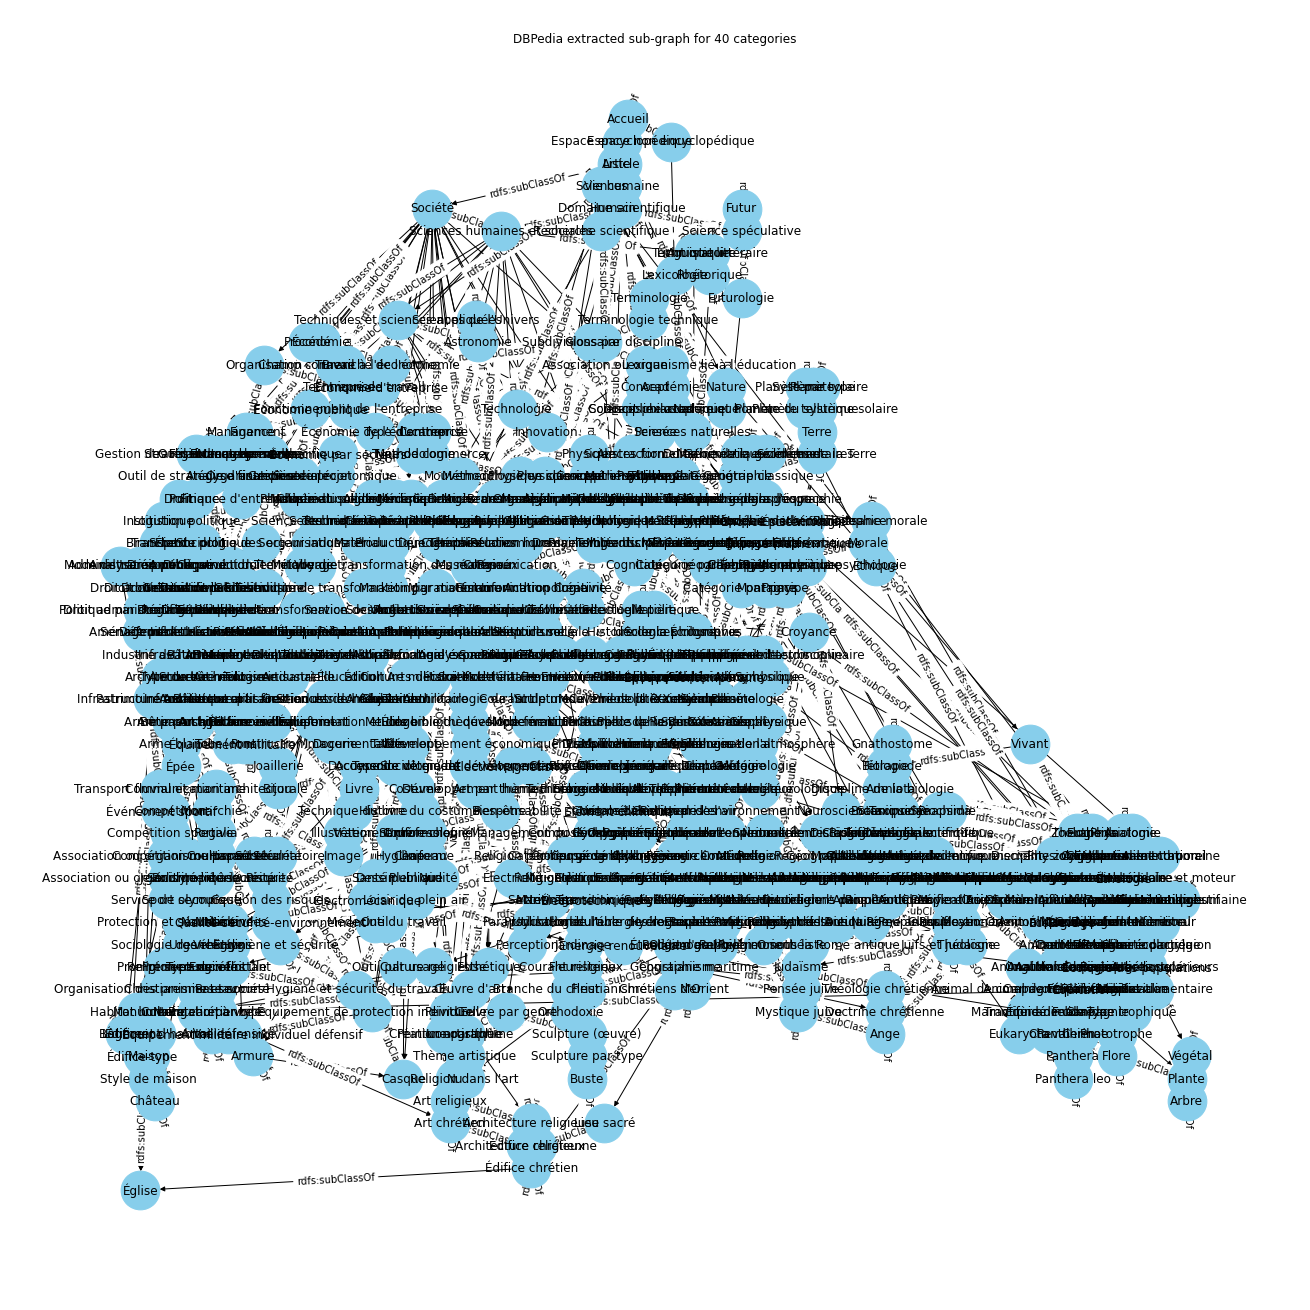

In [74]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

fig=plt.figure(figsize=(18, 18))

fig.suptitle('%s sub-graph for 40 categories' % (graph_config[graph_to_plot][1]) )

g = nx.from_pandas_edgelist(graph_config[graph_to_plot][0],
                            graph_config[graph_to_plot][2],
                            graph_config[graph_to_plot][3],
                            edge_attr=True,
                            create_using=nx.DiGraph())

edge_labels = {(u,v) : graph_config[graph_to_plot][4] for u,v,d in g.edges(data=True)}

#pos = nx.shell_layout(g)

pos=graphviz_layout(g, prog='dot')

nx.draw(g, pos=pos,
        with_labels=True,
        node_size=1500,
        node_color=graph_config[graph_to_plot][5])#, node_shape="s", alpha=0.5)#, linewidths=20)

nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

plt.show()

In [75]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 753
Number of edges: 1444
Average in degree:   1.9177
Average out degree:   1.9177


### Graph Heatmaps

select distance , scale, mask 

In [76]:
heatmap_colors = {
    
    'distance' : ('Greens_r', 'Distance', 'Garnier Thesaurus'),
    
    'similarity_GT' : ('Greens', 'Graph similarity', 'Garnier Thesaurus'),
    'similarity_DBP' : ('Oranges','Graph similarity', 'DBPedia'),
    
    'w_distance_GT' : ('Greens_r', 'Weighted distance', 'Garnier Thesaurus'),
    'w_distance_DBP' : ('Oranges_r', 'Weighted distance', 'DBPedia'),
}

In [79]:
distance_to_plot = 'similarity_DBP'
scale_limits =(0.0, 1)

distance_matrix = similarity_df.pivot('label_A', 'label_B', distance_to_plot ).fillna(0.0)
mask = distance_matrix[(distance_matrix < 100) & (distance_matrix > 0)]
mask = mask.isna()

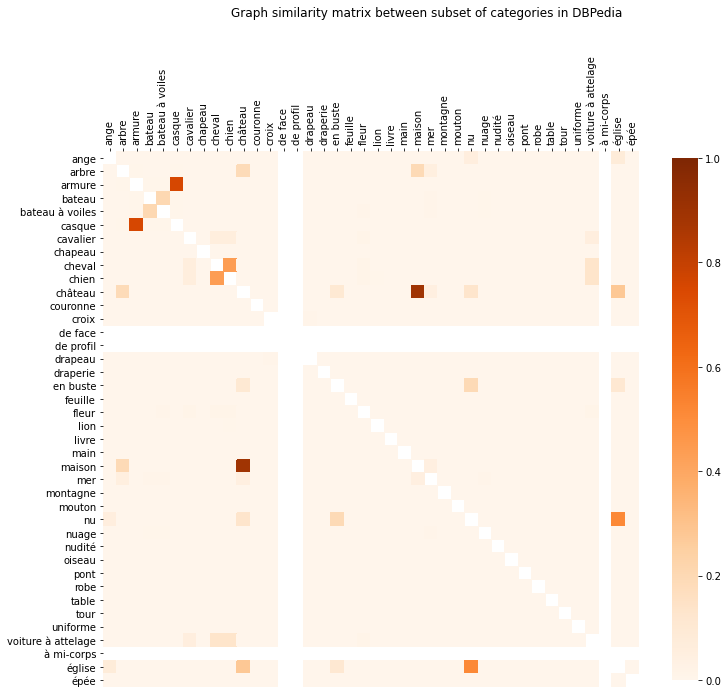

In [80]:
fig=plt.figure(figsize=(12, 12))

fig.suptitle('%s matrix between subset of categories in %s' % (heatmap_colors[distance_to_plot][1],
                                                               heatmap_colors[distance_to_plot][2]))

fig = heatmap_plot(distance_matrix,
                   cmap=heatmap_colors[distance_to_plot][0],
                   annot=False,
                   mask=mask,
                   figure=fig,
                   limits=scale_limits)

### Similarity Bubble plots

select column

In [83]:
indices_colors = {
    
    'Jaccard_index_human' : ('blue', 'Jaccard index', 'human annoatation'),
    'Jaccard_index_pred' :  ('purple', 'Jaccard index', 'predictions'),
    
    'Tversky_index_human' : ('blue', 'Tversky index', 'human annoatation'),
    'Tversky_index_pred' :  ('purple', 'Tversky index', 'predictions'),
    
    'similarity_GT' : ('green', 'graph similarity', 'Garnier Thesaurus'),
    'similarity_DBP' : ('darkorange','graph similarity', 'DBPedia'),
}

In [84]:
index_to_plot = 'similarity_DBP'

index_df = similarity_df[similarity_df[index_to_plot].notna()]

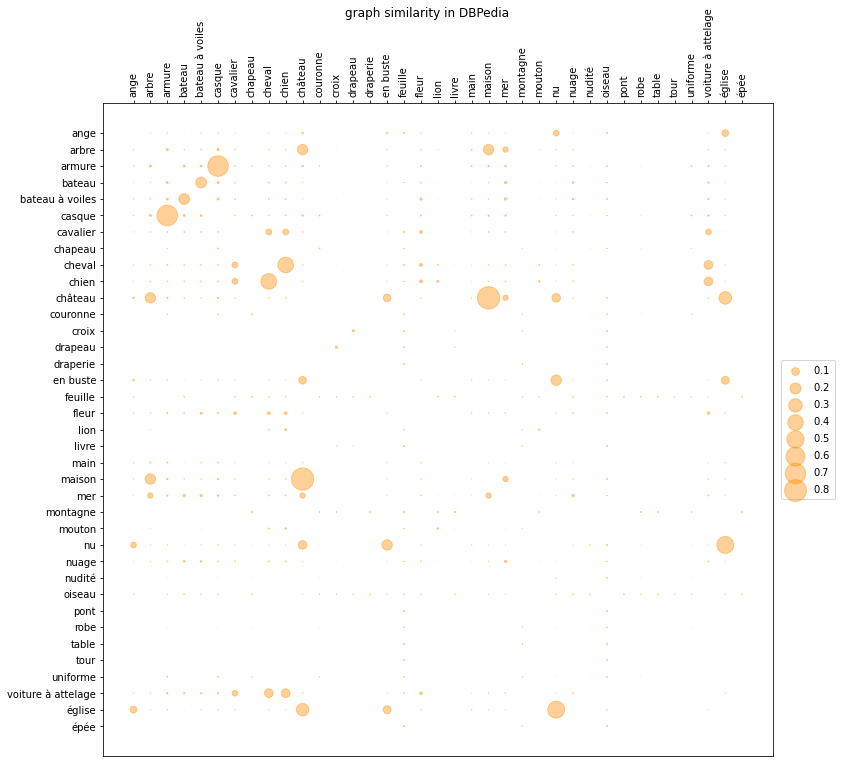

In [85]:
fig = plt.figure(figsize=(12, 12))

fig.suptitle('%s in %s' % (indices_colors[index_to_plot][1] ,
                          indices_colors[index_to_plot][2]) ,
             va='baseline')

fig = bubble_plot(x=index_df.label_A,
                  y=index_df.label_B,
                  z=index_df[index_to_plot] ,
                  zoom = 500, 
                  color= indices_colors[index_to_plot][0],
                  figure=fig, scale=True)

### Top similarity

In [86]:
indices_colors = {
    
    'Jaccard_index_human' : ('Blues_r', 'Jaccard index', 'human annoatation'),
    'Jaccard_index_pred' :  ('Purples_r', 'Jaccard index', 'predictions'),
    
    'Tversky_index_human' : ('Blues_r', 'Tversky index', 'human annoatation'),
    'Tversky_index_pred' :  ('Purples_r', 'Tversky index', 'predictions'),
    
    'similarity_GT' : ('Greens_r', 'graph similarity', 'Garnier Thesaurus'),
    'similarity_DBP' : ('Oranges_r','graph similarity', 'DBPedia'),
    
    'w_distance_GT' : ('Greens', 'weighted distance', 'Garnier Thesaurus'),
    'w_distance_DBP' : ('Oranges', 'weighted distance', 'DBPedia'),
}

In [91]:
index_to_plot = 'Tversky_index_human'
top_filter_threshold = 0.295

top_index_df = similarity_df.sort_values(by=index_to_plot, ascending=False ) \
                                  .loc[similarity_df[index_to_plot] > top_filter_threshold] 

fig_height = min(top_index_df.shape[0] / 2 , 12)

pal = indices_colors[index_to_plot][0]

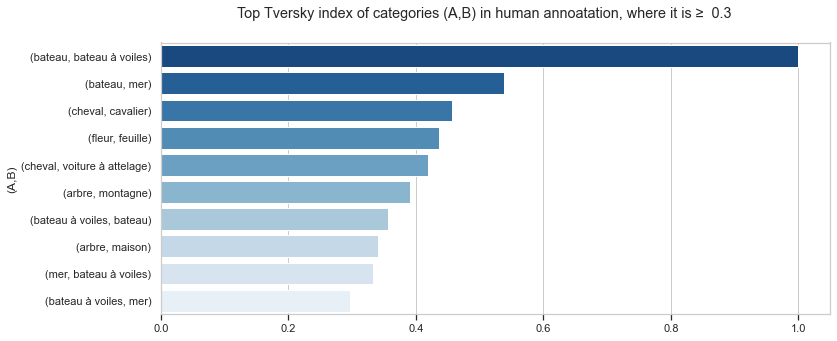

In [92]:
fig=plt.figure(figsize=(12, fig_height))

fig.suptitle('Top %s of categories (A,B) in %s, where it is \u2265  %.1f' % (indices_colors[index_to_plot][1] ,
                                                                             indices_colors[index_to_plot][2] ,
                                                                             round(top_filter_threshold ,1) ) )
    

sink = barplot_pcnt(x= top_index_df[index_to_plot],
                    y= top_index_df.pair,
                    palette = pal,
                    y_label = '(A,B)',
                    show_data_labels = False,
                    figure=fig)

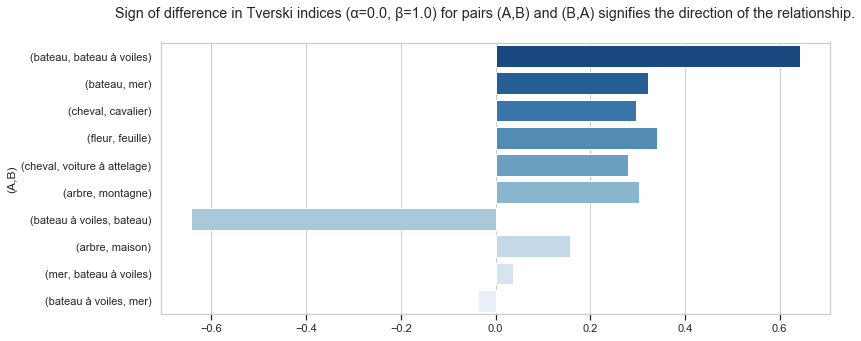

In [1034]:
fig=plt.figure(figsize=(12, fig_height))

if('Tversky' in index_to_plot):
    
    jaccard_index_col = index_to_plot.replace('Tversky', 'Jaccard')

    fig.suptitle('Sign of difference in Tverski indices (\u03B1=0.0, \u03B2=1.0) for pairs (A,B) and (B,A) signifies the direction of the relationship.')

    top_index_df['Tversky_index_diff'] = top_index_df.apply(lambda row: row[index_to_plot] - inverse_index(row[jaccard_index_col], row[index_to_plot]),  axis=1)

    sink = barplot_pcnt(x= top_index_df.Tversky_index_diff ,
                        y= top_index_df.pair,
                        x_label = '',
                        y_label = '(A,B)',
                        show_data_labels = False,
                        figure=fig)

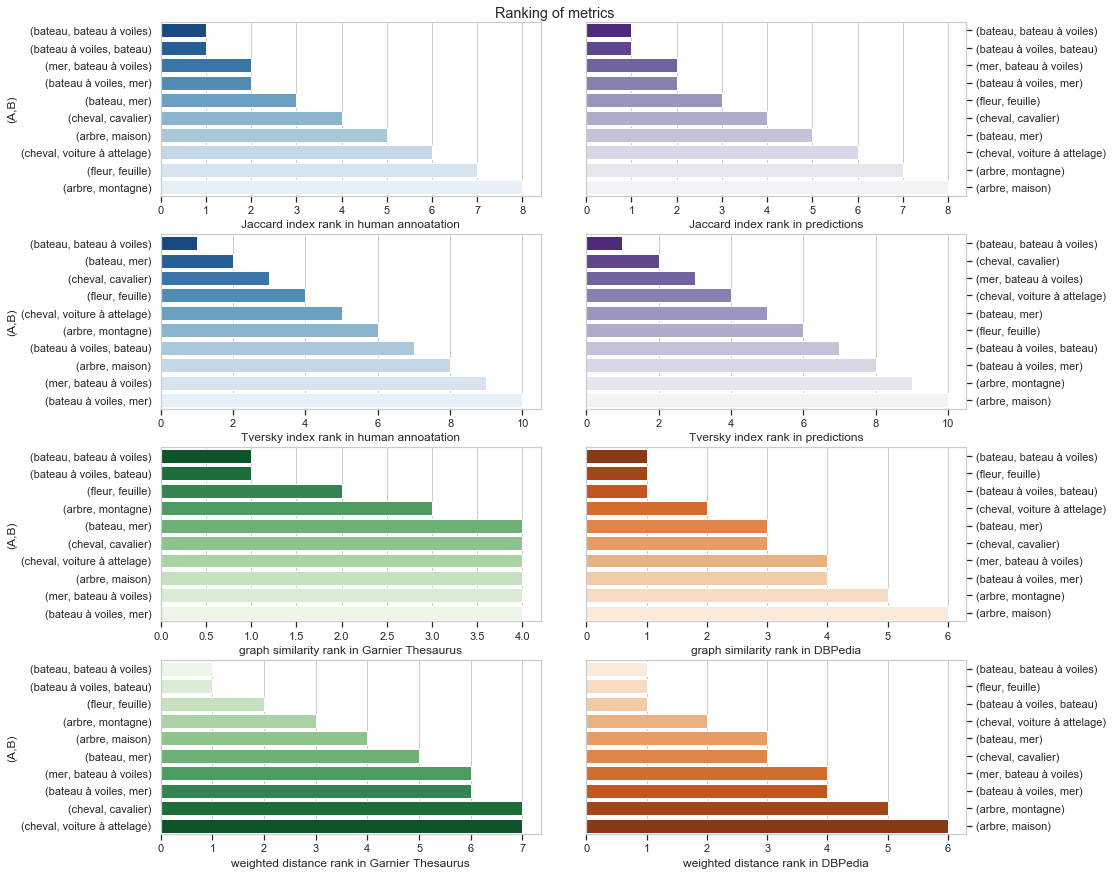

In [1060]:
#TODO:move text inside
fig, axis = plt.subplots(4, 2)  
fig.set_size_inches((12, 12))
plt.tight_layout()

fig.suptitle('Ranking of metrics')

axis = axis.flatten()
    
for i, key in enumerate(indices_colors):

    top_index_df['rank_' + key] = top_index_df[key].rank(method='dense' ,ascending= ('distance' in key))
    ax = sns.barplot(data=top_index_df.sort_values('rank_' + key), 
                x= 'rank_'+ key , y='pair',
                #alpha = 0.4,
                palette= indices_colors[key][0], ci = None, ax=axis[i]) 
    
    ax.xaxis.tick_bottom() # x axis at the bottom
    if (i%2 == 1):
        ax.yaxis.tick_right()
    ax.xaxis.set_label_text(indices_colors[key][1] + ' rank in ' + indices_colors[key][2])
    ax.yaxis.set_label_text('(A,B)' if i%2 == 0 else '')
    

### Compare co-occurrence similarity indices

select metrics to compare, threshold, colors

In [ ]:
comparable_indices_colors = {
    
    'Jaccard_index_human' : sns.color_palette('Blues_r', 10)[5],
    'Jaccard_index_pred' : sns.color_palette('Purples_r', 10)[5],
    
    'Tversky_index_human' : sns.color_palette('Blues_r', 10)[1],
    'Tversky_index_pred' : sns.color_palette('Purples_r', 10)[1],
}

In [863]:
to_compare = ['Tversky_index_human', 'Tversky_index_pred']
top_filter_threshold = 0.295 

compare_df = similarity_df.sort_values(by=to_compare[0], ascending=False ) \
                                  .loc[similarity_df[to_compare[0]] > top_filter_threshold] 

fig_height = min(compare_df.shape[0] / 2 , 12)

compare_df = compare_df.melt(id_vars='pair', 
                             value_vars= to_compare, 
                             var_name='index_name', 
                             value_name='value')

pal = [ comparable_indices_colors[x] for x in to_compare ]

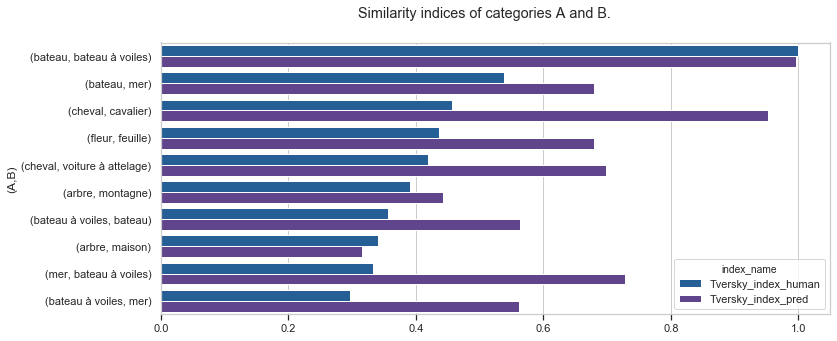

In [867]:
fig=plt.figure(figsize=(12, fig_height))

fig.suptitle('Similarity indices of categories A and B.' )

sink = barplot_pcnt(x= compare_df.value,
                    y= compare_df.pair,
                    hue=compare_df.index_name,
                    palette=pal,
                    x_label = '',
                    y_label = '(A,B)',
                    show_data_labels = False,
                    figure=fig)


### Compare co-occurence similarities and graph distance similarities

select index threshold, co-occurrence similarity index, distance similarity index, colors

In [93]:
comparable_indices_colors = {
    
    'Jaccard_index_human' : 'Blues_r',
    'Jaccard_index_pred' :  'Purples_r',
    
    'Tversky_index_human' : 'Blues_r',
    'Tversky_index_pred' :  'Purples_r',
    
    'similarity_GT' : 'Greens',
    'similarity_DBP' : 'Oranges',
    
    'w_distance_GT' : 'Greens',
    'w_distance_DBP' : 'Oranges',
}

In [100]:
cooc_index_name = 'Tversky_index_human'
dist_index_name = 'w_distance_DBP'
top_cooccurrence_threshold = 0.295 

# step 1
ranking_df = similarity_df.sort_values(by=cooc_index_name, ascending=False ) \
                                  .loc[similarity_df[cooc_index_name] > top_cooccurrence_threshold] 

ranking_df = ranking_df.loc[ranking_df[dist_index_name].notna()]
# step 2
ranking_df['rank_' + cooc_index_name] = ranking_df[cooc_index_name].rank(method='dense', ascending=False)
ranking_df['rank_' + dist_index_name] = ranking_df[dist_index_name].rank(method='dense', ascending= ('distance' in dist_index_name))
# step 3
ranking_df['rank_diff'] = (ranking_df['rank_' + cooc_index_name]- ranking_df['rank_' + dist_index_name])

ranking_df = ranking_df.sort_values(by='rank_diff').reset_index()

c1 = sns.color_palette(comparable_indices_colors[cooc_index_name], ranking_df[ranking_df.rank_diff <= 0.0].shape[0])#negative numbers
c2 = sns.color_palette(comparable_indices_colors[dist_index_name], ranking_df[ranking_df.rank_diff > 0.0].shape[0])#positive numbers

fig_height = min(ranking_df.shape[0] / 2 , 12)

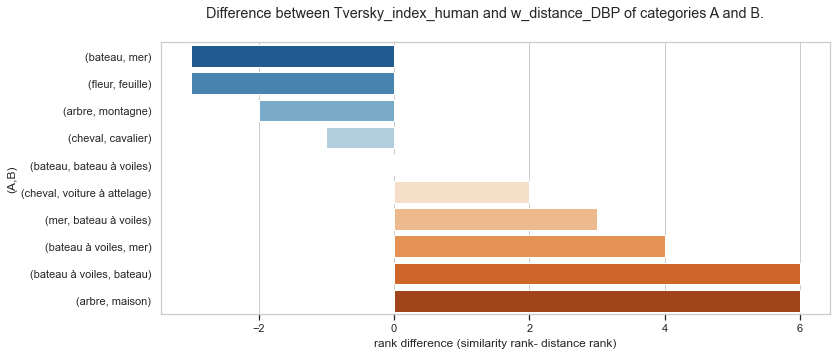

In [101]:
fig=plt.figure(figsize=(12, fig_height))

fig.suptitle('Difference between %s and %s of categories A and B.' % (cooc_index_name, dist_index_name) )

#step 4
sink = barplot_pcnt(x= ranking_df.rank_diff ,
                    y= ranking_df.pair,
                    palette= c1 + c2,
                    x_label = 'rank difference (similarity rank- distance rank)',
                    y_label = '(A,B)',
                    show_data_labels = False,
                    figure=fig)

## Scrapbook

## Target vs. Prediction Coocurence [Asymetric]

In [ ]:
query_target_prediction_cooccurence = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
prefix ml: <http://ns.inria.fr/monalia/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

select
(?topCategory_label as ?label_A)
(?detectedCat_label as ?label_B)
(count(distinct ?noticeReference) as ?cooccurence_count)
where
{
    {
      select 
        ?noticeReference 
        ?topCategory_label
        (group_concat(?subCategory_label;  separator="+") as ?subcat)
        (sample(?classifier) as ?classifier_)
         where { 
                {
                    select (?classifierClass_label as ?topCategory_label )
                    where 
                      {
                        ?classifierType ml:vocabID "REPR" .
                        ?classifier rdfs:subClassOf ?classifierType.
                        ?classifier rdfs:label "40_classes". #?classifierName.
                        ?classifier ml:conatainsClass [a ?classifierClass; skos:prefLabel ?classifierClass_label]
          
                        #filter (?classifierClass_label = "chien"@fr)
                      }
                }
			?topCategory a jcl:Term;
				   skos:prefLabel ?topCategory_label;
				   skos:narrower* ?subCategory.
				
			?subCategory  skos:prefLabel ?subCategory_label.

			?notice jcl:noticeReprTerm ?subCategory;
					jcl:noticeHasImage true;               
					jcl:noticeRef ?noticeReference.
		}
		group by ?noticeReference ?topCategory_label
		order by ?noticeReference ?topCategory_label
	}
               
    ?n  jcl:noticeRef ?noticeReference;
        jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImagePath ?imagePath].
  
    ?n jcl:noticeRepr ?noticeRepresentation.
  
   {
  	 select ?n ?detectedCat_label ?detectedScore
     where 
      {
         ?n ml:imageClassifier [ a ?classifier_;
                                 ml:detected [ a ?detectedCat; ml:score ?detectedScore] ].
   		 ?detectedCat skos:prefLabel ?detectedCat_label.
      
			FILTER ( ?detectedScore >= 0.9 )
      }

   }
	  
} 

group by ?topCategory_label ?detectedCat_label
order by desc (?cooccurence_count)

'''

In [ ]:
%time target_predictions = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_target_prediction_cooccurence)

In [ ]:
target_predictions.cooccurence_count = target_predictions.cooccurence_count.astype('int32')
print(target_predictions.shape)
target_predictions.info()

In [ ]:
target_predictions_ = target_predictions.loc[target_predictions.label_A != target_predictions.label_B , :]
target_predictions_.shape

In [ ]:
target_predictions

## Combine Distance and Coocurence

Calculate cooccurence-distance coefficient as

$$coocurenceDistanceCoef = \frac{coocurence}{sumOfOccurencesOfTargetLabels} * distance_{weighted}$$

and sort by it in the decending order. 

**The top records are potential missing links.**

### Merge distance and cooccurence tables

In [ ]:
target_predictions_ = target_predictions_.merge(distance.loc[:, ['start_label', 'end_label', 'distance', 'w_distance', 'common_parent_count']],
                                                left_on=['topCategory_label', 'detectedCat_label'], 
                                                right_on=['start_label', 'end_label'] )


In [ ]:
target_predictions_.sort_values(by='cooccurence_count', ascending=False).head()

### Calculate aggregated coefficient

In [ ]:
total_target_count = target_predictions.groupby(by='topCategory_label').sum()
total_target_count

In [ ]:
target_predictions_['n_cooccurence_count'] = target_predictions_.apply(lambda x: x.cooccurence_count/total_target_count.loc[x.topCategory_label][0], axis=1)
target_predictions_['coocc_dist_coef'] = target_predictions_.apply(lambda x: x.n_cooccurence_count * x.w_distance, axis=1)

In [ ]:
target_predictions_.loc[:, ['topCategory_label', 'detectedCat_label', 'coocc_dist_coef', 'common_parent_count']
                ].sort_values('coocc_dist_coef', ascending=False).head()